# I FEATURES

In [2]:
from datasets import get_dataset_split_names
from datasets import load_dataset
from datasets import dataset_dict
from datasets import arrow_dataset
import string

dataset = load_dataset("imdb")

/home/amine/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset imdb (/home/amine/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 48.88it/s]


In [3]:
def preprocess(data : dict) -> dict:
    '''Takes a document from a dataset, lowers the letters and
    replace all punctuations by spaces'''
    text = data["text"]
    for character in string.punctuation:
        if character != "-" and character != "!":
          text = text.replace(character, ' ')
    data["text"] = text.lower()
    return data

In [4]:
updated_dataset= dataset.map(preprocess)

Loading cached processed dataset at /home/amine/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-a1ff6ac6f3dae5b2.arrow
Loading cached processed dataset at /home/amine/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-3ff24866f561b56d.arrow
Loading cached processed dataset at /home/amine/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c8e6bf051898815c.arrow


In [10]:
import math
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def build_single_feature(text : string) -> np.array:
    '''Create a vector containing the information of the text classified by features'''

    word_count = 0
    base_vector = [0,0,0,0.0,0,0]
    feature_vector = np.array(base_vector)
    Analyser = SentimentIntensityAnalyzer()

    for word in text.split():
        word_count += 1
        if (word == "no") :
            feature_vector[0] = 1
        if (word == "i" or word == "you") :
            feature_vector[1] +=  1
        if (word == "!") :
            feature_vector[2] = 1
        test_dict = Analyser.polarity_scores(word)
        if (test_dict["compound"] >= 0.05):
            feature_vector[4] += 1
        elif (test_dict["compound"] <= -0.05):
            feature_vector[5] += 1
    feature_vector[3] = math.log(word_count)

    return feature_vector

def build_all_features(dataset : dataset_dict.DatasetDict) -> np.ndarray:
    '''Construct a list of the vectors of features from the documents contained in dataset'''
    list_vector = []
    for document in dataset:
        feature_vector = build_single_feature(document["text"])
        list_vector.append(feature_vector)
    features_vector = np.array(list_vector)

    return features_vector

TypeError: 'type' object is not iterable

In [11]:
train_feature_vectors = build_all_features(updated_dataset["train"])
test_feature_vectors = build_all_features(updated_dataset["test"])

numpy.ndarray

# II REGRESSION LINEAIRE

# 1- Adaptation of the code with our vectors of features

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch import nn

In [13]:
# Forcing the random seed for reproductibility
np.random.seed(seed=42)

train_labels = updated_dataset["train"]["label"]
test_labels = updated_dataset["test"]["label"]


In [14]:
df = pd.DataFrame()
df["no"] = train_feature_vectors[:, 0]
df["pronouns"] = train_feature_vectors[:, 1]
df["!"] = train_feature_vectors[:, 2]
df["Log(word_count)"] = train_feature_vectors[:, 3]
df["positive"] = train_feature_vectors[:, 4]
df["negative"] = train_feature_vectors[:, 5]


df["label"] = train_labels



In [15]:

all_points = torch.tensor(train_feature_vectors, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(test_feature_vectors, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype= torch.float32).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    all_points,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=10,
)



In [16]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

In [17]:
model = LogisticRegression(6, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)



In [18]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)


tensor(0.8084, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5829, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5836, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5834, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5834, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5834, grad_fn=<BinaryCrossEntropyBackward0>)
CPU times: user 12.7 s, sys: 60 ms, total: 12.8 s
Wall time: 3.24 s


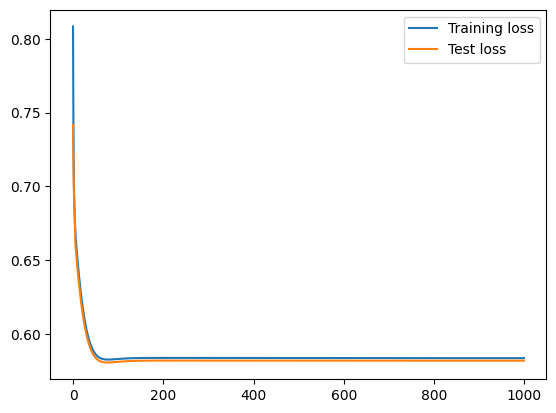

In [19]:
# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()


# 2- Evaluate the classifier in terms of accuracy for the training

In [20]:
# Computing the accuracy for our 3 splits.
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = model(X_valid)
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy,valid_accuracy, test_accuracy)

0.7114 0.7176 0.71408


# 3- The weights : Which features seems to play most to both classes

In [21]:
# Looking at the model's weights and bias.
model.classifier[0].state_dict()["weight"], model.classifier[0].state_dict()["bias"]


(tensor([[-0.0303, -0.0486, -0.0064, -0.0175,  0.1239, -0.1441]]),
 tensor([-0.0027]))

En analysant les différents poids, on observe que celui qui semble influencer le plus sur nos classes sont celui correspondant à la gestion du lexique positif et celui correspondant à la gestion du lexique négatif.

# 4- Take two wrongly classified samples in the test set and try explaining why the model was wrong.

In [22]:
with torch.no_grad():
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    y_test_numpy = y_test.numpy()
    i = 0
    found = 0
    while found < 2:
        if p_test[i] != y_test_numpy[i]:
            print(dataset['test'][i])
            print(X_test[i])
            print()
            print()
            print()
            print()
            found += 1
        i += 1

    test_accuracy = np.mean(p_test == y_test.numpy())

{'text': "First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!", 'label': 0}
tensor([ 0.0000,  4.0000,  0.0000,  4.9127, 14.0000,  2.0000])




{'text': "Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can tell Isaac has a real passio

Le premier document ne comporte aucun signe relevable dans les vecteurs d'analyse : pas de "no" (bien que beaucoup de négation "not" et "don't"), pas de termes particulièrement positifs ou négatifs, ni "!". A partir du vecteur, on peut juste penser que le texte est très neutre, d'où l'erreur du modèle.

Concernant le second texte, il comporte de nombreux mots positifs, et pratiquement aucun mot négatif. L'auteur a particulièrement aimé le film, mais avec la nuance que c'est parce qu'il est fan de Van Damme : même s'il a beaucoup apprécié, il indique que son avis est limité en tant que fan, d'où l'estimation générale négative. Le modèle a donc estimé le texte comme positif.